# 01-Time Series Forecasting: Tutorial 1

### - 구간평균법 
### - 단순지수평활법 
### - 이중지수평활법 
### - 홀트-윈터지수평활법 

### 1. 모듈 불러오기

In [1]:
import os

import pandas as pd
# import pandas_datareader.data as pdr

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

from sklearn.datasets import fetch_openml
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import seaborn as sns
#sns.set_style("white")

import itertools
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 

/tmp/ipykernel_347101/1285615463.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### 2. 데이터 불러오기

In [2]:
co2_data = pd.read_csv('co2.csv')
# co2_data = pd.read_csv('../input/lg-time-series-day02-dataset/co2.csv')

#### 2.1 Data Preprocessing

In [3]:
'''
년/월/일 병합하여 'data' 변수 생성
'''
co2_data['date'] = pd.to_datetime(co2_data[['year', 'month', 'day']]) 
data = co2_data[['date', 'co2']].set_index('date')
data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
data.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-17', '1958-05-24',
               '1958-07-05', '1958-07-12',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', name='date', length=2225, freq=None)

In [5]:
data = data.asfreq('W-SAT')
data.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', name='date', length=2284, freq='W-SAT')

In [6]:
data.isnull().sum()

co2    59
dtype: int64

In [7]:
data = data.fillna(data.bfill())
data.isnull().sum()

co2    0
dtype: int64

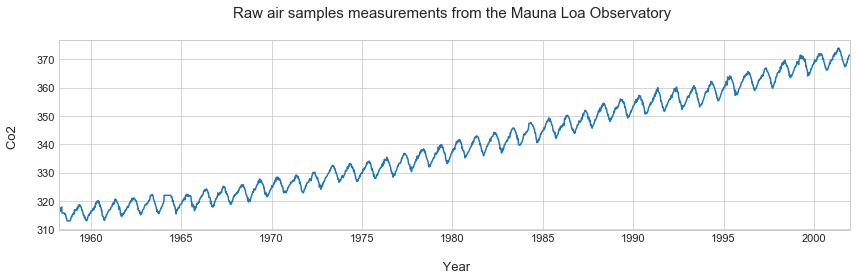

In [8]:
'''
데이터 시각화를 통해 전체 개요 확인
'''
data.plot(figsize=(12,4)) # color='green', linestyle='--', linewidth=1

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend('')

plt.title('Raw air samples measurements from the Mauna Loa Observatory \n', fontsize=15)
plt.xlabel('\n Year', fontsize=13)
plt.ylabel('Co2 \n', fontsize=13)
plt.tight_layout()
plt.show()

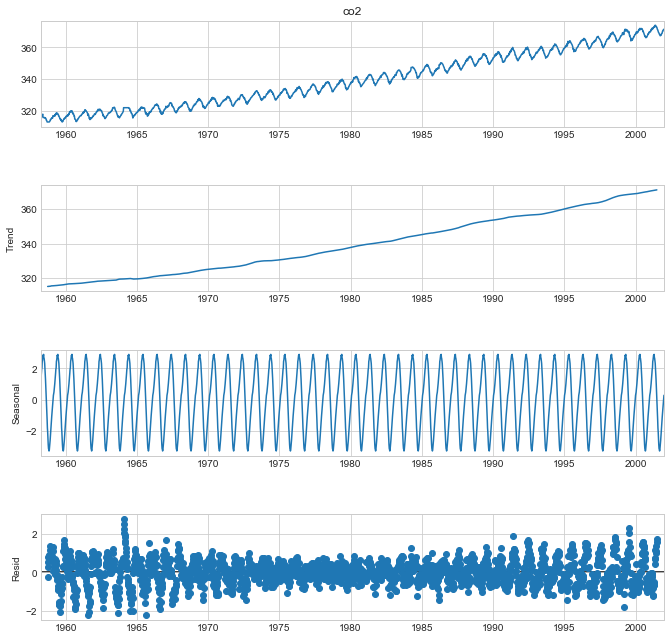

In [9]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

decompostion = sm.tsa.seasonal_decompose(data['co2'],  model='additive')

fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

In [10]:
'''
Train Test Split
'''
train = data[:'1989-12']
test  = data['1990-01':]

### 3. Moving Average (구간평균법)

In [11]:
'''
Version 1
'''
def Moving_Average(x, N):
    x = x.values.flatten()
    
    pred = np.convolve(x, np.ones(N) / float(N), 'valid')
    pred = np.concatenate((np.zeros(N-1), pred), axis=0)
    pred[:N-1] = np.nan
    return pred

MA_train_pred = pd.DataFrame(Moving_Average(train, 5), index=train.index, columns=['MA_5'])
MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])

print('Moving Average Train results')
print(MA_train_pred)
print('-'*30)
print('Moving Average Test results')
print(MA_test_pred)

Moving Average Train results
              MA_5
date              
1958-03-29     NaN
1958-04-05     NaN
1958-04-12     NaN
1958-04-19     NaN
1958-04-26  316.98
...            ...
1989-12-02  351.36
1989-12-09  351.66
1989-12-16  351.90
1989-12-23  352.08
1989-12-30  352.48

[1658 rows x 1 columns]
------------------------------
Moving Average Test results
              MA_5
date              
1990-01-06  352.48
1990-01-13  352.48
1990-01-20  352.48
1990-01-27  352.48
1990-02-03  352.48
...            ...
2001-12-01  352.48
2001-12-08  352.48
2001-12-15  352.48
2001-12-22  352.48
2001-12-29  352.48

[626 rows x 1 columns]


In [12]:
'''
Version 2
'''
MA_train_pred = train.rolling(5).mean() # Option: min_periods=1
MA_train_pred.columns = ['MA_5']

MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])
prediction = pd.concat([MA_train_pred, MA_test_pred], axis=0)

print('Moving Average Train Results')
print(MA_train_pred)
print('-'*30)
print('Moving Average Test Results')
print(MA_test_pred)

Moving Average Train Results
              MA_5
date              
1958-03-29     NaN
1958-04-05     NaN
1958-04-12     NaN
1958-04-19     NaN
1958-04-26  316.98
...            ...
1989-12-02  351.36
1989-12-09  351.66
1989-12-16  351.90
1989-12-23  352.08
1989-12-30  352.48

[1658 rows x 1 columns]
------------------------------
Moving Average Test Results
              MA_5
date              
1990-01-06  352.48
1990-01-13  352.48
1990-01-20  352.48
1990-01-27  352.48
1990-02-03  352.48
...            ...
2001-12-01  352.48
2001-12-08  352.48
2001-12-15  352.48
2001-12-22  352.48
2001-12-29  352.48

[626 rows x 1 columns]


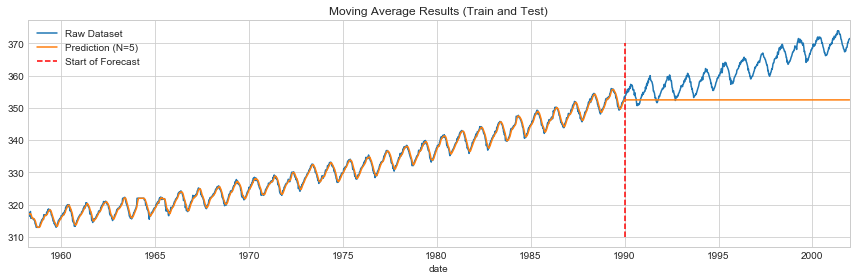

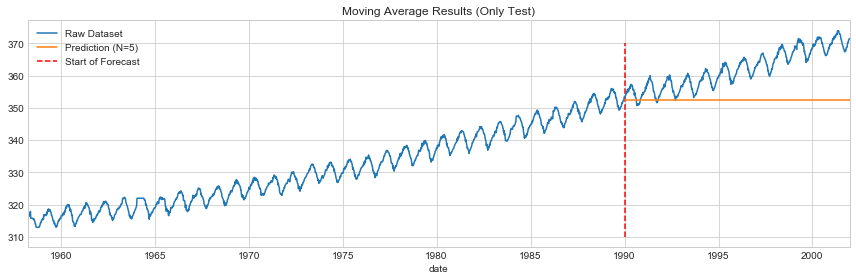

In [13]:
'''
Visualization 
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
prediction.plot(ax=ax, label = 'Prediction (N=5)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (N=5)', 'Start of Forecast'], loc='upper left')
plt.title('Moving Average Results (Train and Test)')
plt.tight_layout()
plt.show()

# Only Test
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
MA_test_pred.plot(ax=ax, label = 'Prediction (N=5)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (N=5)', 'Start of Forecast'], loc='upper left')
plt.title('Moving Average Results (Only Test)')
plt.tight_layout()
plt.show()

##### 정량적 지표를 통한 모델 검증

###### Mean Squared Error (평균 제곱 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$   

In [14]:
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')

MSE: 125.46


######  Root Mean Squared Error (제곱근 평균 제곱 오차) <br>
$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}}$

In [15]:
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')

RMSE: 11.2


##### Mean Absolute Error (평균 절대 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$

In [16]:
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')

MAE: 9.59


#####  R squared (결정계수 $({r})^{2}$) <br>
$\frac{SSR}{SST} = 1- \frac{SSR}{SST}%$

In [17]:
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

R2 score: -2.63


### 4. Exponential Smoothing (지수평활법)

#### 4.1 Simple Exponential Smoothing (단순지수평활법)

In [18]:
L_0 = np.mean(train)  # initial value

SES_train = train.copy()
SES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['co2']), SES_train])
SES_train['Level'] = np.nan
SES_train['Forecast'] = np.nan
SES_train.loc[0,'Level'] = L_0.values

SES_train

,co2,Level,Forecast
0,0.0,331.216767,NaN
1958-03-29 00:00:00,316.1,NaN,NaN
1958-04-05 00:00:00,317.3,NaN,NaN
1958-04-12 00:00:00,317.6,NaN,NaN
1958-04-19 00:00:00,317.5,NaN,NaN
...,...,...,...
1989-12-02 00:00:00,352.0,NaN,NaN
1989-12-09 00:00:00,352.1,NaN,NaN
1989-12-16 00:00:00,352.4,NaN,NaN
1989-12-23 00:00:00,352.5,NaN,NaN


In [19]:
'''
Version 1
'''
def Simple_Exponential_Smoothing(table, alpha):
    # table = SES_train.copy()
    # alpha = 0.9
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'co2']
        L_prev = table.loc[list(table.index)[i-1],'Level']
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev)

        L_pred = table.iloc[-1,1]
        SES_test_pred = [L_pred]*len(test)
        SES_test_pred = pd.DataFrame(SES_test_pred, index=test.index, columns=[f'SES_{alpha}'])
        
    return table, SES_test_pred

In [20]:
SES_train_pred, SES_test_pred = Simple_Exponential_Smoothing(SES_train, 0.9)

In [21]:
print('Simple Exponential Smoothing Train Results')
print(SES_train_pred)
print('-'*30)
print('Simple Exponential Smoothing Test results')
print(SES_test_pred)

Simple Exponential Smoothing Train Results
                       co2       Level  Forecast
0                      0.0  331.216767       NaN
1958-03-29 00:00:00  316.1  317.611677       NaN
1958-04-05 00:00:00  317.3  317.331168       NaN
1958-04-12 00:00:00  317.6  317.573117       NaN
1958-04-19 00:00:00  317.5  317.507312       NaN
...                    ...         ...       ...
1989-12-02 00:00:00  352.0  351.941538       NaN
1989-12-09 00:00:00  352.1  352.084154       NaN
1989-12-16 00:00:00  352.4  352.368415       NaN
1989-12-23 00:00:00  352.5  352.486842       NaN
1989-12-30 00:00:00  353.4  353.308684       NaN

[1659 rows x 3 columns]
------------------------------
Simple Exponential Smoothing Test results
               SES_0.9
date                  
1990-01-06  353.308684
1990-01-13  353.308684
1990-01-20  353.308684
1990-01-27  353.308684
1990-02-03  353.308684
...                ...
2001-12-01  353.308684
2001-12-08  353.308684
2001-12-15  353.308684
2001-12-22  353.30

In [22]:
'''
Version 2
'''

SES_train_pred_09 = pd.concat([pd.DataFrame([L_0], columns=['co2']), train]).ewm(alpha=0.9, adjust=False).mean().iloc[1:]
SES_train_pred_09.columns = ['SES_09']
SES_test_pred_09 = pd.DataFrame(np.array([SES_train_pred_09.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_09'])
prediction_09 = pd.concat([SES_train_pred_09, SES_test_pred_09], axis=0)

SES_train_pred_05 = pd.concat([pd.DataFrame([L_0], columns=['co2']), train]).ewm(alpha=0.5, adjust=False).mean().iloc[1:]
SES_train_pred_05.columns = ['SES_05']
SES_test_pred_05 = pd.DataFrame(np.array([SES_train_pred_05.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_05'])
prediction_05 = pd.concat([SES_train_pred_05, SES_test_pred_05], axis=0)

SES_train_pred_01 = pd.concat([pd.DataFrame([L_0], columns=['co2']), train]).ewm(alpha=0.1, adjust=False).mean().iloc[1:]
SES_train_pred_01.columns = ['SES_01']
SES_test_pred_01 = pd.DataFrame(np.array([SES_train_pred_01.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_01'])
prediction_01 = pd.concat([SES_train_pred_01, SES_test_pred_01], axis=0)

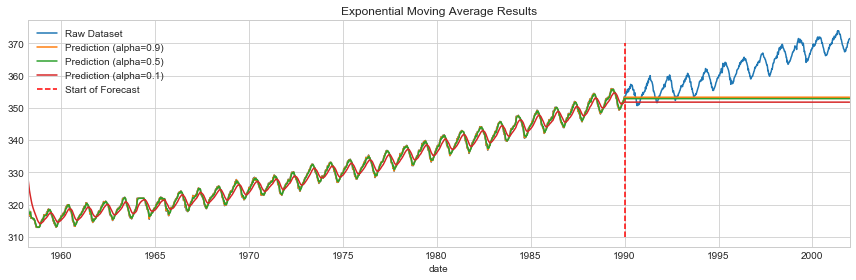

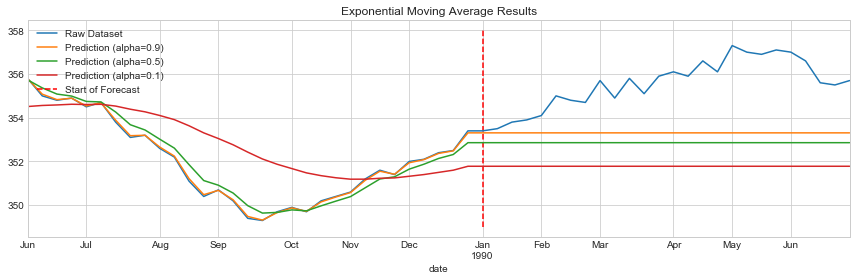

In [23]:
'''
Visualization 
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
prediction_09.plot(ax=ax, label = 'Prediction (alpha=0.9)')
prediction_05.plot(ax=ax, label = 'Prediction (alpha=0.5)')
prediction_01.plot(ax=ax, label = 'Prediction (alpha=0.1)')

ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (alpha=0.9)', 'Prediction (alpha=0.5)', 'Prediction (alpha=0.1)', 'Start of Forecast'], loc='upper left')
plt.title('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

# Only Test
fig, ax = plt.subplots(figsize=(12,4))
data['1989-06':'1990-06'].plot(ax=ax)
prediction_09['1989-06':'1990-06'].plot(ax=ax, label = 'Prediction (alpha=0.9)')
prediction_05['1989-06':'1990-06'].plot(ax=ax, label = 'Prediction (alpha=0.5)')
prediction_01['1989-06':'1990-06'].plot(ax=ax, label = 'Prediction (alpha=0.1)')

ax.vlines(test.index[0], 349, 358, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (alpha=0.9)', 'Prediction (alpha=0.5)', 'Prediction (alpha=0.1)', 'Start of Forecast'], loc='upper left')
plt.title('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [24]:
'''
Quantitative Evaluation
'''
print('-'*30)
print('alpha  = 0.9')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_09), 2)}')

print('-'*30)
print('alpha  = 0.5')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_05), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_05)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_05), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_05), 2)}')

print('-'*30)
print('alpha  = 0.1')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_01), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_01)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_01), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_01), 2)}')

------------------------------
alpha  = 0.9
MSE: 110.34
RMSE: 10.5
MAE: 8.82
R2 score: -2.19
------------------------------
alpha  = 0.5
MSE: 118.37
RMSE: 10.88
MAE: 9.23
R2 score: -2.43
------------------------------
alpha  = 0.1
MSE: 139.28
RMSE: 11.8
MAE: 10.25
R2 score: -3.03


#### 4.2 Double Exponential Smoothing (이중지수평활법)

In [25]:
'''
Searching Initialization Points
'''
train_reg = train.reset_index()
x = np.array(train_reg.index)
y = train_reg['co2']

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()

print(results.summary())
L_0, B_0 = results.params

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 3.215e+04
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:49:54   Log-Likelihood:                -3885.3
No. Observations:                1658   AIC:                             7775.
Df Residuals:                    1656   BIC:                             7785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        311.9941      0.124   2519.870      0.0

In [26]:
DES_train = train.copy()
DES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['co2']), DES_train])
DES_train['Level'] = np.nan
DES_train['Trend'] = np.nan
DES_train['Forecast'] = np.nan

DES_train.loc[0,'Level'] = L_0
DES_train.loc[0,'Trend'] = B_0

DES_train

,co2,Level,Trend,Forecast
0,0.0,311.994132,0.023202,NaN
1958-03-29 00:00:00,316.1,NaN,NaN,NaN
1958-04-05 00:00:00,317.3,NaN,NaN,NaN
1958-04-12 00:00:00,317.6,NaN,NaN,NaN
1958-04-19 00:00:00,317.5,NaN,NaN,NaN
...,...,...,...,...
1989-12-02 00:00:00,352.0,NaN,NaN,NaN
1989-12-09 00:00:00,352.1,NaN,NaN,NaN
1989-12-16 00:00:00,352.4,NaN,NaN,NaN
1989-12-23 00:00:00,352.5,NaN,NaN,NaN


In [27]:
def Double_Exponential_Smoothing(table, alpha, beta):
    # table = DES_train.copy()
    # alpha = 0.16
    # beta = 0.1
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'co2']
        L_prev = table.loc[list(table.index)[i-1],'Level']
        T_prev = table.loc[list(table.index)[i-1],'Trend']
        
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev+T_prev)
        table.loc[list(table.index)[i],'Trend'] = beta*(table.loc[list(table.index)[i],'Level']-L_prev) + (1-beta)*(T_prev)

        L_Pred = table.iloc[-1,1]
        T_Pred = table.iloc[-1,2]
        
        DES_test_pred = L_Pred + range(len(test))*T_Pred
        DES_test_pred = pd.DataFrame(DES_test_pred, index = test.index, columns=['DES'])
        
    return table, DES_test_pred

In [28]:
DES_train_pred, DES_test_pred = Double_Exponential_Smoothing(DES_train, 0.16, 0.1)

In [29]:
print('Double Exponential Smoothing Train Results')
print(DES_train_pred)
print('-'*30)
print('Double Exponential Smoothing Test results')
print(DES_test_pred)

Double Exponential Smoothing Train Results
                       co2       Level     Trend  Forecast
0                      0.0  311.994132  0.023202       NaN
1958-03-29 00:00:00  316.1  312.670560  0.088524       NaN
1958-04-05 00:00:00  317.3  313.485631  0.161179       NaN
1958-04-12 00:00:00  317.6  314.279320  0.224430       NaN
1958-04-19 00:00:00  317.5  314.983150  0.272370       NaN
...                    ...         ...       ...       ...
1989-12-02 00:00:00  352.0  349.904718 -0.122128       NaN
1989-12-09 00:00:00  352.1  350.153375 -0.085050       NaN
1989-12-16 00:00:00  352.4  350.441394 -0.047743       NaN
1989-12-23 00:00:00  352.5  350.730667 -0.014041       NaN
1989-12-30 00:00:00  353.4  351.145965  0.028893       NaN

[1659 rows x 4 columns]
------------------------------
Double Exponential Smoothing Test results
                   DES
date                  
1990-01-06  351.145965
1990-01-13  351.174858
1990-01-20  351.203751
1990-01-27  351.232643
1990-02-03  3

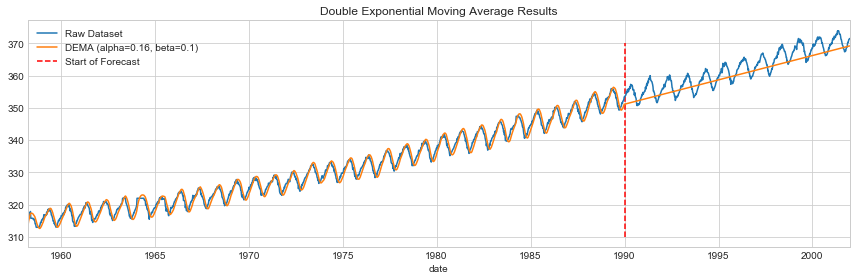

In [30]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(DES_train_pred.iloc[1:,1])
train_pred.columns = ['DES']
DES_pred = pd.concat([train_pred, DES_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
DES_pred.plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'DEMA (alpha=0.16, beta=0.1)', 'Start of Forecast'], loc='upper left')
plt.title('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [31]:
'''
Quantitative Evaluation
'''
print('-'*30)
print('alpha  = 0.16, beta = 0.1')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

------------------------------
alpha  = 0.16, beta = 0.1
MSE: 8.82
RMSE: 2.97
MAE: 2.5
R2 score: 0.74


#### 4.3 Holt-Winter's Exponential Smoothing (홀트-윈터 지수평활법)

##### 4.3.1 Additive Winter's method

In [32]:
train

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
1989-12-02,352.0
1989-12-09,352.1
1989-12-16,352.4


In [33]:
# HW_add_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(smoothing_level=alpha, smoothing_trend=gamma, smoothing_seasonal=delta)
HW_add_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True)
HW_add_model.summary()

Dep. Variable:,endog,No. Observations:,1658
Model:,ExponentialSmoothing,SSE,240.299
Optimized:,True,AIC,-3090.401
Trend:,Additive,BIC,-2787.252
Seasonal:,Additive,AICC,-3086.121
Seasonal Periods:,52,Date:,"Mon, 10 Jan 2022"
Box-Cox:,False,Time:,16:49:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6048083,alpha,True
smoothing_slope,5.6559e-17,beta,True


In [34]:
HW_add_train_pred = HW_add_model.fittedvalues
HW_add_test_pred = HW_add_model.forecast(len(test))
HW_add_test_pred = pd.DataFrame(HW_add_test_pred, index=test.index, columns=['HW_add'])

print('Additive Holt-Winter Exponential Smoothing Train Results')
print(HW_add_train_pred)
print('-'*30)
print('Additive Holt-Winter Smoothing Test results')
print(HW_add_test_pred)

Additive Holt-Winter Exponential Smoothing Train Results
date
1958-03-29    316.357012
1958-04-05    316.598717
1958-04-12    317.158632
1958-04-19    317.776835
1958-04-26    317.875332
                 ...    
1989-12-02    351.794290
1989-12-09    352.170960
1989-12-16    352.387319
1989-12-23    352.491047
1989-12-30    352.810086
Freq: W-SAT, Length: 1658, dtype: float64
------------------------------
Additive Holt-Winter Smoothing Test results
                HW_add
date                  
1990-01-06  353.449921
1990-01-13  353.618823
1990-01-20  353.745317
1990-01-27  353.890383
1990-02-03  354.069489
...                ...
2001-12-01  366.719373
2001-12-08  366.815431
2001-12-15  367.129055
2001-12-22  367.412106
2001-12-29  367.581007

[626 rows x 1 columns]


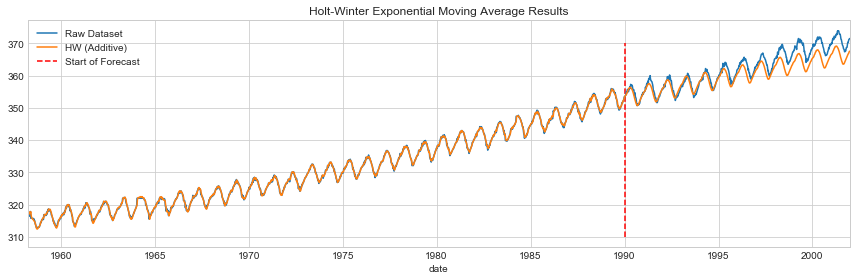

In [35]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(HW_add_train_pred, columns=['HW_add'])
HW_add_pred = pd.concat([train_pred, HW_add_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
HW_add_pred.plot(ax=ax, label = 'Prediction (Additive)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'HW (Additive)', 'Start of Forecast'], loc='upper left')
plt.title('Holt-Winter Exponential Moving Average Results')
plt.tight_layout()
plt.show()

##### 4.3.2 Multiplicative Winter's method

In [37]:
HW_mul_model = ExponentialSmoothing(train, trend='mul', seasonal='mul').fit(optimized=True)
HW_mul_model.summary()

Dep. Variable:,endog,No. Observations:,1658
Model:,ExponentialSmoothing,SSE,240.377
Optimized:,True,AIC,-3089.864
Trend:,Multiplicative,BIC,-2786.716
Seasonal:,Multiplicative,AICC,-3085.584
Seasonal Periods:,52,Date:,"Mon, 10 Jan 2022"
Box-Cox:,False,Time:,16:49:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6108238,alpha,True
smoothing_slope,1.0943e-23,beta,True


In [38]:
HW_mul_train_pred = HW_mul_model.fittedvalues
HW_mul_test_pred = HW_mul_model.forecast(len(test))
HW_mul_test_pred = pd.DataFrame(HW_mul_test_pred, index=test.index, columns=['HW_mul'])

print('Multiplicative Holt-Winter Exponential Smoothing Train Results')
print(HW_mul_train_pred)
print('-'*30)
print('Multiplicative Holt-Winter Smoothing Test results')
print(HW_mul_test_pred)

Multiplicative Holt-Winter Exponential Smoothing Train Results
date
1958-03-29    317.279679
1958-04-05    316.939207
1958-04-12    317.290236
1958-04-19    317.814961
1958-04-26    317.879990
                 ...    
1989-12-02    351.821910
1989-12-09    352.197755
1989-12-16    352.415245
1989-12-23    352.508231
1989-12-30    352.841952
Freq: W-SAT, Length: 1658, dtype: float64
------------------------------
Multiplicative Holt-Winter Smoothing Test results
                HW_mul
date                  
1990-01-06  353.485492
1990-01-13  353.659126
1990-01-20  353.789814
1990-01-27  353.942624
1990-02-03  354.122019
...                ...
2001-12-01  368.346184
2001-12-08  368.453109
2001-12-15  368.807185
2001-12-22  369.123246
2001-12-29  369.304562

[626 rows x 1 columns]


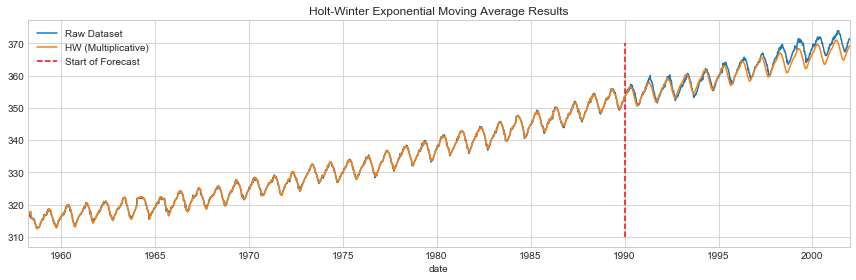

In [39]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(HW_mul_train_pred, columns=['HW_mul'])
HW_mul_pred = pd.concat([train_pred, HW_mul_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
HW_mul_pred.plot(ax=ax, label = 'Prediction (Multiplicative)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'HW (Multiplicative)', 'Start of Forecast'], loc='upper left')
plt.title('Holt-Winter Exponential Moving Average Results')
plt.tight_layout()
plt.show()

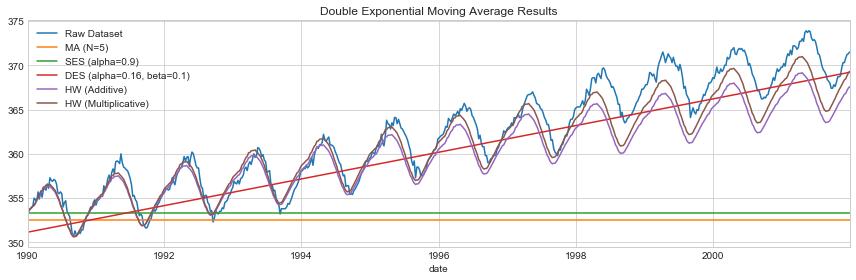

In [40]:
'''
Comparing
'''
fig, ax = plt.subplots(figsize=(12,4))
data['1990-01':].plot(ax=ax)
MA_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (N=5)')
SES_test_pred_09['1990-01':].plot(ax=ax, label = 'Prediction (alpha=0.9)')
DES_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
HW_add_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (additive)')
HW_mul_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (Multiplicative)')


ax.legend(['Raw Dataset', 'MA (N=5)', 'SES (alpha=0.9)', 'DES (alpha=0.16, beta=0.1)', 'HW (Additive)', 'HW (Multiplicative)'], loc='upper left')
plt.title('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [41]:
'''
Quantitative Evaluation
'''
print('-'*55)
print('Moving Average (N = 5)')
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

print('-'*55)
print('Simple Exponential Smoothing (alpha = 0.9)')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_09), 2)}')

print('-'*55)
print('Double Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

print('-'*55)
print('Additive Holt-Winter Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, HW_add_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_add_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_add_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_add_test_pred), 2)}')

print('-'*55)
print('Multiplicative Holt-Winter Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, HW_mul_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_mul_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_mul_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_mul_test_pred), 2)}')

-------------------------------------------------------
Moving Average (N = 5)
MSE: 125.46
RMSE: 11.2
MAE: 9.59
R2 score: -2.63
-------------------------------------------------------
Simple Exponential Smoothing (alpha = 0.9)
MSE: 110.34
RMSE: 10.5
MAE: 8.82
R2 score: -2.19
-------------------------------------------------------
Double Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 8.82
RMSE: 2.97
MAE: 2.5
R2 score: 0.74
-------------------------------------------------------
Additive Holt-Winter Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 7.0
RMSE: 2.65
MAE: 2.05
R2 score: 0.8
-------------------------------------------------------
Multiplicative Holt-Winter Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 3.53
RMSE: 1.88
MAE: 1.44
R2 score: 0.9


In [42]:
test_predict_results = pd.concat([test, MA_test_pred, SES_test_pred_09, DES_test_pred, HW_add_test_pred, HW_mul_test_pred], axis=1)
test_predict_results

,co2,MA_5,SES_09,DES,HW_add,HW_mul
date,,,,,,
1990-01-06,353.4,352.48,353.308684,351.145965,353.449921,353.485492
1990-01-13,353.5,352.48,353.308684,351.174858,353.618823,353.659126
1990-01-20,353.8,352.48,353.308684,351.203751,353.745317,353.789814
1990-01-27,353.9,352.48,353.308684,351.232643,353.890383,353.942624
1990-02-03,354.1,352.48,353.308684,351.261536,354.069489,354.122019
...,...,...,...,...,...,...
2001-12-01,370.3,352.48,353.308684,369.088332,366.719373,368.346184
2001-12-08,370.8,352.48,353.308684,369.117225,366.815431,368.453109
2001-12-15,371.2,352.48,353.308684,369.146118,367.129055,368.807185


# EOD